# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #1:
- Task 1: Dependencies and OpenAI API Key
- Task 2: Basic RAG Chain
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset

✋BREAKOUT ROOM #2:
- Task 1: Parent Document Retriever
- Task 2: Ensemble Retriever

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for a simple RAG system built on top of LangChain's blogs!

In [1]:
!pip install langchain_core langchain_openai langchain_community langchain-qdrant qdrant-client langsmith openai tiktoken cohere -qU

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

## Task 2: Basic RAG Chain

Now we'll set up our basic RAG chain, first up we need a model!

### OpenAI Model


We'll use OpenAI's `gpt-3.5-turbo` model to ensure we can use a stronger model for decent evaluation later!

Notice that we can tag our resources - this will help us be able to keep track of which resources were used where later on!

In [3]:
from langchain_openai.chat_models import ChatOpenAI

base_llm = ChatOpenAI(
    model='gpt-3.5-turbo',
    tags=["base_llm"]
)


#### Asyncio Bug Handling

This is necessary for Colab.

In [4]:
import nest_asyncio
nest_asyncio.apply()

### SiteMap Loader

We'll use a SiteMapLoader to scrape the LangChain blogs.

In [5]:
from langchain.document_loaders import SitemapLoader

documents = SitemapLoader(web_path="https://blog.langchain.dev/sitemap-posts.xml").load()

USER_AGENT environment variable not set, consider setting it to identify your requests.
Fetching pages: 100%|##########| 221/221 [00:26<00:00,  8.50it/s]


In [6]:
documents[0].metadata["source"]

'https://blog.langchain.dev/what-is-an-agent/'

### RecursiveCharacterTextSplitter

We're going to use a relatively naive text splitting strategy today!

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

split_documents = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 500,
    chunk_overlap = 20
).split_documents(documents)

In [8]:
len(split_documents)

1548

### Embeddings

We'll be leveraging OpenAI's [text-embedding-3-small](https://openai.com/index/new-embedding-models-and-api-updates/) today!

In [9]:
from langchain_openai.embeddings import OpenAIEmbeddings

base_embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

### Qdrant VectorStore Retriever

Now we can use a Qdrant VectorStore to embed and store our documents and then convert it to a retriever so it can be used in our chain!

In [10]:
from langchain_qdrant import Qdrant

vectorstore = Qdrant.from_documents(
    split_documents,
    base_embeddings_model,
    location=":memory:",
    collection_name="langchainblogs")

In [11]:
base_retriever = vectorstore.as_retriever()

### Prompt Template

All we have left is a prompt template, which we'll create here!

In [12]:
from langchain.prompts import ChatPromptTemplate

base_rag_prompt_template = """\
Using the provided context, please answer the user's question. If you don't know the answer based on the context, say you don't know.

Context:
{context}

Question:
{question}
"""

base_rag_prompt = ChatPromptTemplate.from_template(base_rag_prompt_template)

### LCEL Chain

Now that we have:

- Embeddings Model
- Generation Model
- Retriever
- Prompt

We're ready to build our LCEL chain!

Keep in mind that we're returning our source documents with our queries - while this isn't necessary, it's a great thing to get into the habit of doing.

In [13]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

base_rag_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": base_rag_prompt | base_llm | StrOutputParser(), "context": itemgetter("context")}
)

Let's test it out!

In [14]:
base_rag_chain.invoke({"question" : "What is a good way to evaluate agents?"})["response"]

'A good way to evaluate agents is by testing their capabilities in common agentic workflows such as planning, task decomposition, function calling, and the ability to override pre-trained biases when needed. It is also important to assess their performance across different tasks and analyze their behavior patterns before deploying them.'

## Task 3: Setting Up LangSmith

Now that we have a chain - we're ready to get started with LangSmith!

We're going to go ahead and use the following `env` variables to get our Colab notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [15]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"LangSmith - {unique_id}"

### LangSmith API

In order to use LangSmith - you will need a beta key, you can join the queue through the `Beta Sign Up` button on LangSmith's homepage!

Join [here](https://www.langchain.com/langsmith)

In [16]:
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

Let's test our our first generation!

In [17]:
base_rag_chain.invoke({"question" : "What is LangSmith?"}, {"tags" : ["Demo Run"]})['response']

'LangSmith is a unified platform for debugging, testing, evaluating, and monitoring LLM applications.'

## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.


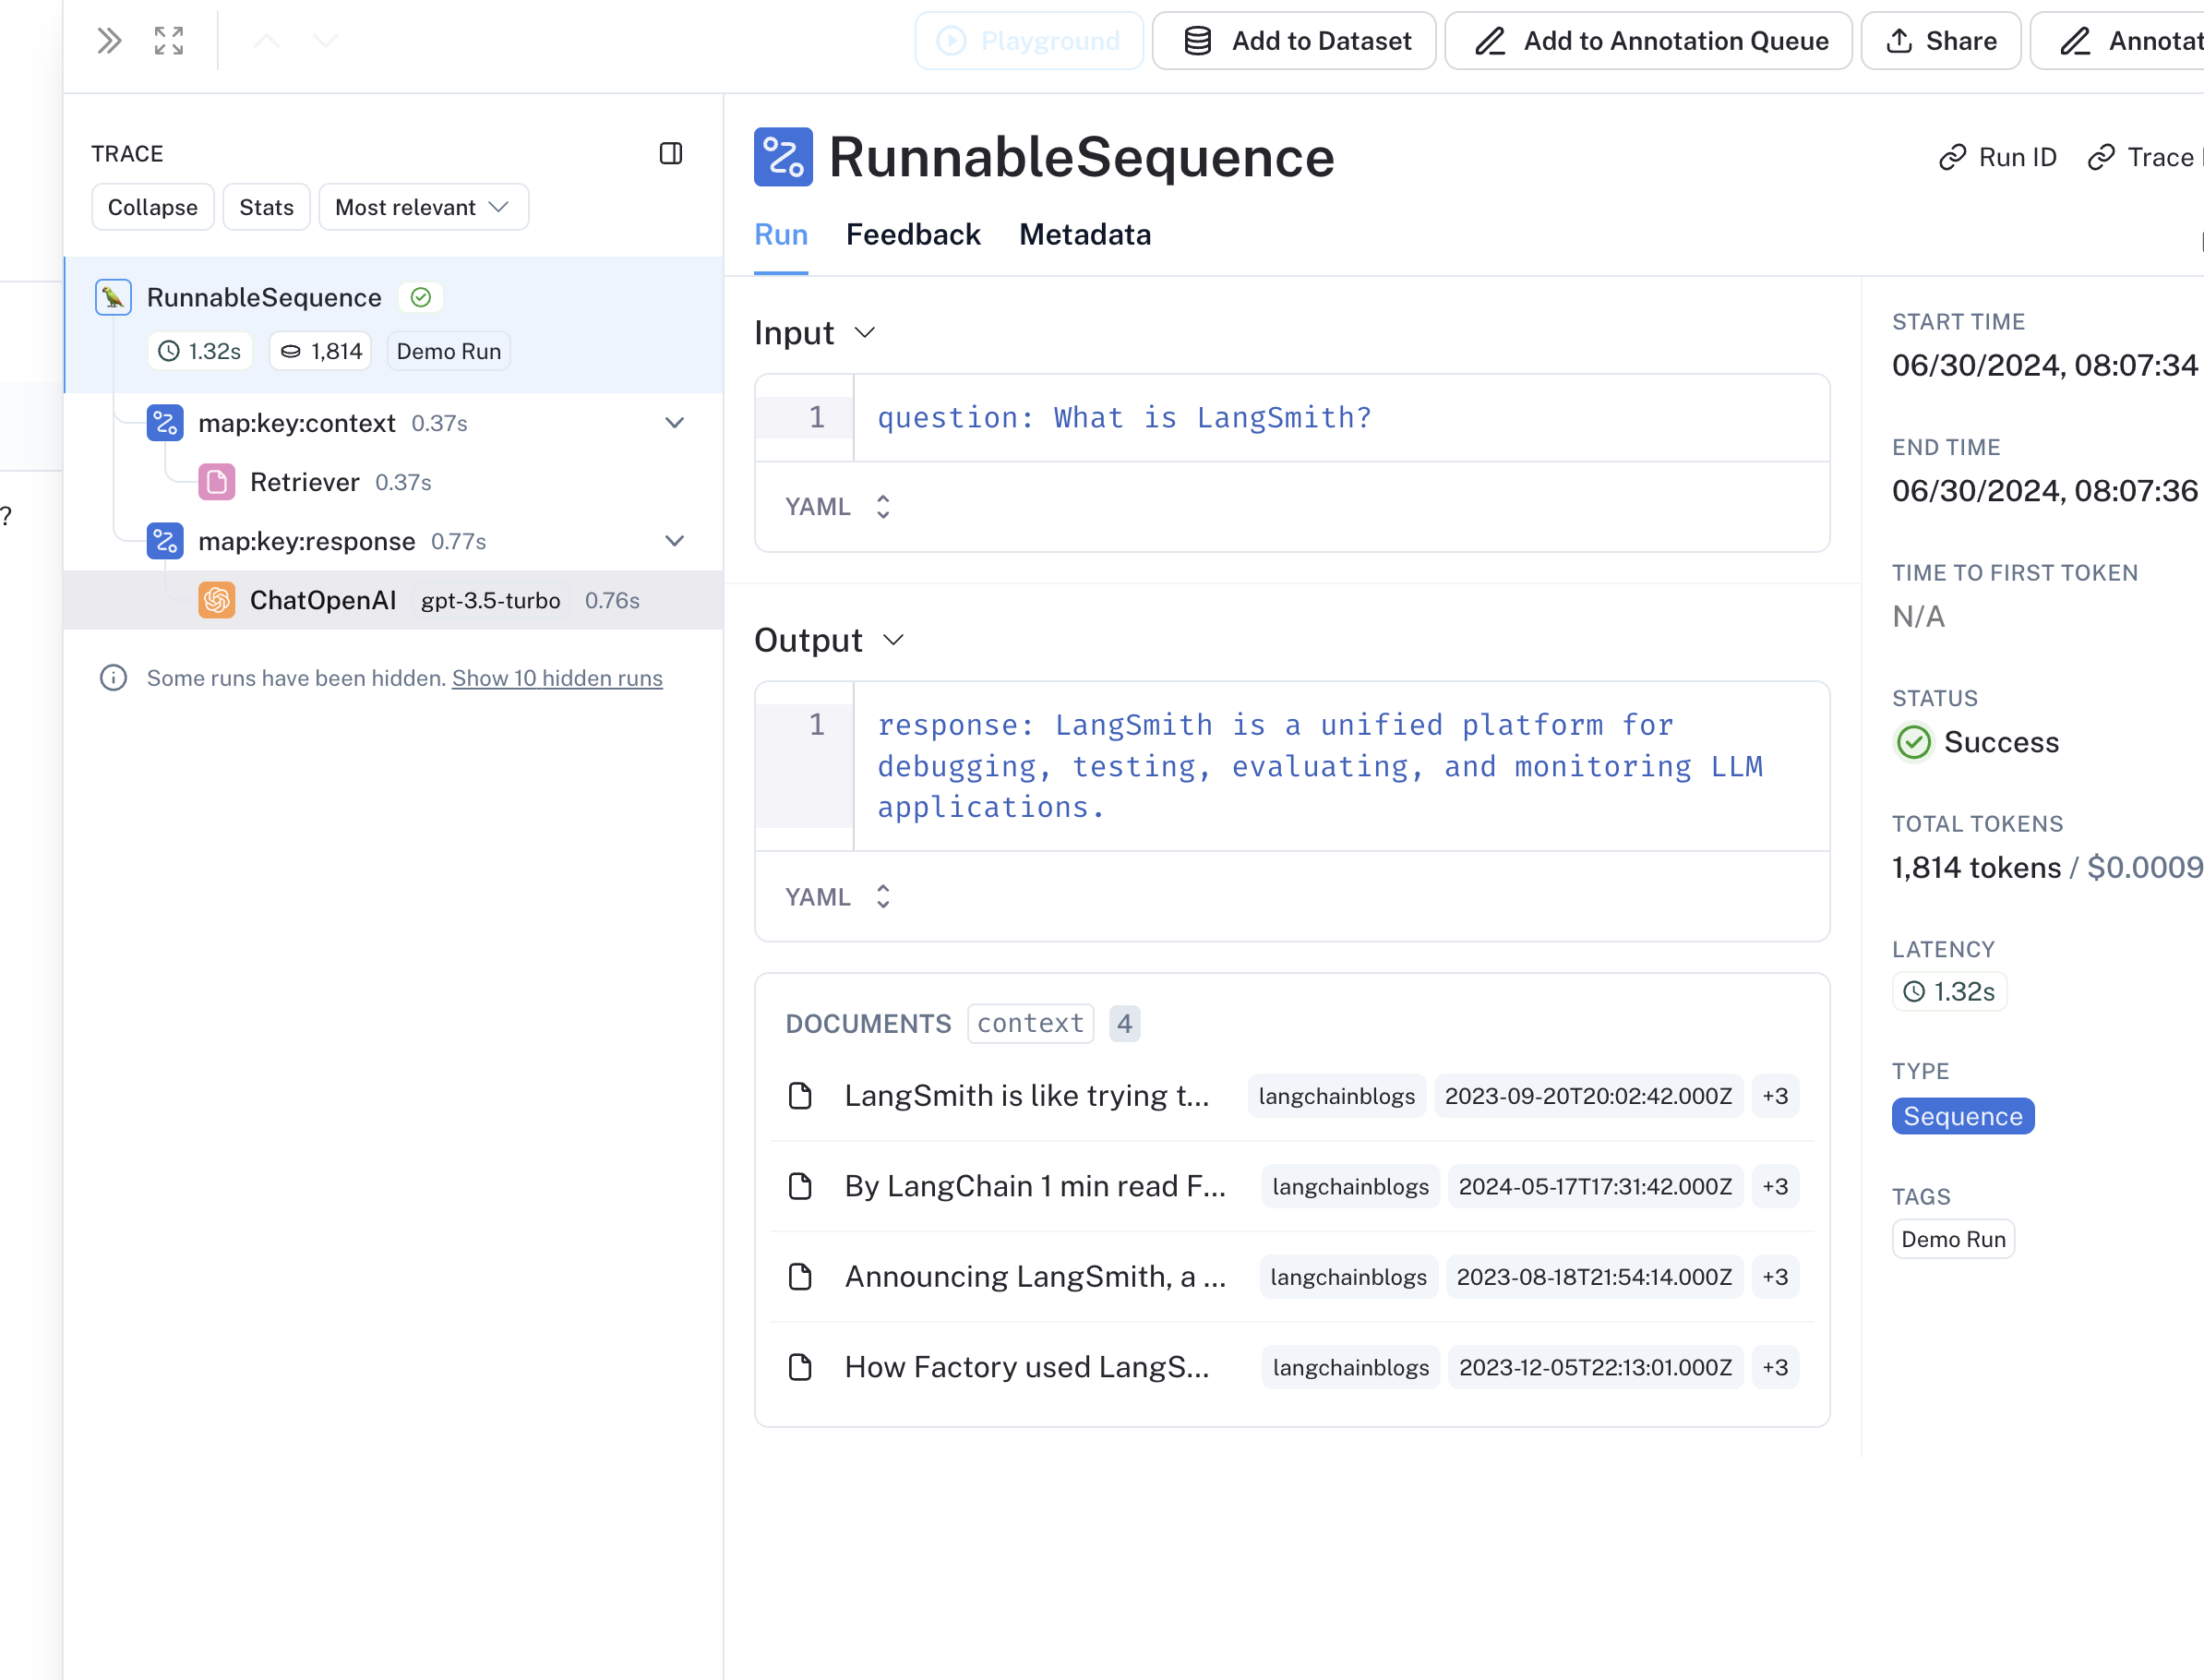

![image]()

## Task 5: Create Testing Dataset

Now we can create a dataset using some user defined questions, and providing the retrieved context as a "ground truth" context.

> NOTE: There are many different ways you can approach this specific task - generating ground truth answers with AI, using human experts to generate golden datasets, and more!

### Synthetic Data Generation (SDG)

In order to full test our RAG chain, and the various modifications we'll be using in the following notebook, we'll need to create a small synthetic dataset that is relevant to our task!

Let's start by generating a series of questions - which begins with a simple model definition!

> NOTE: We're going to be using a purposefully simplified datagen pipeline as an example today - but you could leverage the RAGAS SDG pipeline just as easily.

In [18]:
question_model = ChatOpenAI(model="gpt-4o")

Next up, we'll create some novel chunks from our source data!

In [19]:
sdg_documents = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 1000,
    chunk_overlap = 20
).split_documents(documents)

Now, let's ask some questions that could be answered from the provided chunks!

In [20]:
question_prompt_template = """\
You are a University Professor creating questions for an exam. You must create a question for a given piece of context.

The question must be answerable only using the provided context.

Avoid creating questions that are ambiguous or vague. They should be specifically related to the context.

Your output must only be the question.

Context:
{context}
"""

question_prompt = ChatPromptTemplate.from_template(question_prompt_template)

In [21]:
question_chain = question_prompt | question_model

Now we can loop through a subset of our context chunks and create question/context pairs!

In [22]:
from tqdm import tqdm
import json

question_context_pairs = []

for idx in tqdm(range(0, len(sdg_documents), 40)):
  question = question_chain.invoke({"context" : sdg_documents[idx].page_content})
  question_context_pairs.append({"question" : question.content, "context" : sdg_documents[idx].page_content, "idx" : idx})


100%|██████████| 23/23 [00:16<00:00,  1.35it/s]


In [23]:
question_context_pairs[0]

{'question': 'According to the context, what is the topic of the new series introduced by Harrison Chase on June 28, 2024?',
 'context': 'What is an agent?\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to content\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAll Posts\n\n\n\n\nRelease Notes\n\n\n\n\nCase Studies\n\n\n\n\nIn the Loop\n\n\n\n\nLangChain\n\n\n\n\nDocs\n\n\n\n\n\nSign in\nSubscribe\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nWhat is an agent?\nIntroducing a new series of musings on AI agents.\n\nHarrison Chase\n4 min read\nJun 28, 2024',
 'idx': 0}

We'll repeat this process for answers!

In [24]:
answer_prompt_template = """\
You are a University Professor creating an exam. You must create a answer for a given piece of context and question.

The answer must only rely on the provided context.

Your output must only be the answer.

Context:
{context}
"""

answer_prompt = ChatPromptTemplate.from_template(answer_prompt_template)

In [25]:
answer_chain = answer_prompt | question_model

In [26]:
for question_context_pair in tqdm(question_context_pairs):
  question_context_pair["answer"] = answer_chain.invoke({"question" : question_context_pair["question"], "context" : question_context_pair["context"]}).content

100%|██████████| 23/23 [00:27<00:00,  1.21s/it]


In [27]:
question_context_pairs[0]

{'question': 'According to the context, what is the topic of the new series introduced by Harrison Chase on June 28, 2024?',
 'context': 'What is an agent?\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to content\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAll Posts\n\n\n\n\nRelease Notes\n\n\n\n\nCase Studies\n\n\n\n\nIn the Loop\n\n\n\n\nLangChain\n\n\n\n\nDocs\n\n\n\n\n\nSign in\nSubscribe\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nWhat is an agent?\nIntroducing a new series of musings on AI agents.\n\nHarrison Chase\n4 min read\nJun 28, 2024',
 'idx': 0,
 'answer': 'An agent is related to AI agents in the context provided.'}

Now we can set up our LangSmith client - and we'll add the above created dataset to our LangSmith instance!

> NOTE: Read more about this process [here](https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets#create-from-list-of-values)

In [28]:
from langsmith import Client

client = Client()

dataset_name = "langsmith-demo-dataset-v1"

dataset = client.create_dataset(
    dataset_name=dataset_name, description="LangChain Blog Test Questions"
)

for triplet in question_context_pairs:
  client.create_example(
      inputs={"question" : triplet["question"]},
      outputs={"answer" : triplet["answer"]},
      dataset_id=dataset.id
  )

### Evaluation

Now we can run the evaluation!

We'll need to start by preparing some custom data preparation functions to ensure our chain works with the expected inputs/outputs from the `evaluate` process in LangSmith.

> NOTE: More reading on this available [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#evaluate-a-langchain-runnable)

In [29]:
def prepare_data_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.outputs["answer"],
      "input" : example.inputs["question"]
  }

def prepare_data_noref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "input" : example.inputs["question"]
  }

We'll be using a few custom evaluators to evaluate our pipeline, as well as a few "built in" methods!

Check out the built-ins [here](https://docs.smith.langchain.com/reference/sdk_reference/langchain_evaluators)!

In [32]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

cot_qa_evaluator = LangChainStringEvaluator("cot_qa", prepare_data=prepare_data_ref)

unlabeled_dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria" : {
            "dopeness" : "Is the answer to the question dope, meaning cool - awesome - and legit?"
        }
    },
    prepare_data=prepare_data_noref
)

labeled_score_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": {
            "accuracy": "Is the generated answer the same as the reference answer?"
        },
    },
    prepare_data=prepare_data_ref
)

unlabeled_coherence_evaluator = LangChainStringEvaluator("criteria", config={ "criteria": "coherence"}, prepare_data=prepare_data_noref)
labeled_relevance_evaluator = LangChainStringEvaluator("criteria", config={ "criteria": "relevance"}, prepare_data=prepare_data_ref)


base_rag_results = evaluate(
    base_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        unlabeled_coherence_evaluator,
        labeled_relevance_evaluator
        ],
    experiment_prefix="Base RAG Evaluation"
)

Exception in thread Exception in threading.excepthook:
Exception ignored in thread started by: <bound method Thread._bootstrap of <Thread(Thread-12 (<lambda>), stopped 123145588269056)>>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/threading.py", line 1002, in _bootstrap
    self._bootstrap_inner()
  File "/opt/anaconda3/lib/python3.11/threading.py", line 1047, in _bootstrap_inner
    self._invoke_excepthook(self)
  File "/opt/anaconda3/lib/python3.11/threading.py", line 1359, in invoke_excepthook
    local_print("Exception in threading.excepthook:",
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/iostream.py", line 573, in flush
    self.pub_thread.schedule(self._flush)
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/iostream.py", line 266, in schedule
    self._event_pipe.send(b"")
  File "/opt/anaconda3/lib/python3.11/site-packages/zmq/sugar/socket.py", line 696, in send
    return super().send(data, flags=flags, copy=copy, tra

View the evaluation results for experiment: 'Base RAG Evaluation-e06d9d12' at:
https://smith.langchain.com/o/f09a66be-9170-5efe-b80c-65a19489cb73/datasets/6db351dd-3651-4796-a630-44089c9973bf/compare?selectedSessions=e6efdcf0-078a-427a-a916-3d610d1e7902




## Testing Other Retrievers

Now we can test our how changing our Retriever impacts our LangSmith evaluation!

We'll build this simple qa_chain factory to create standardized qa_chains where the only different component will be the retriever.

In [ ]:
def create_qa_chain(retriever):
  primary_qa_llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
  created_qa_chain = (
    {"context": itemgetter("question") | retriever,
     "question": itemgetter("question")
    }
    | RunnablePassthrough.assign(
        context=itemgetter("context")
      )
    | {
         "response": base_rag_prompt | primary_qa_llm,
         "context": itemgetter("context"),
      }
  )
  return created_qa_chain

### Task 1: Parent Document Retriever

One of the easier ways we can imagine improving a retriever is to embed our documents into small chunks, and then retrieve a significant amount of additional context that "surrounds" the found context.

You can read more about this method [here](https://python.langchain.com/docs/modules/data_connection/retrievers/parent_document_retriever)!

The basic outline of this retrieval method is as follows:

1. Obtain User Question
2. Retrieve child documents using Dense Vector Retrieval
3. Merge the child documents based on their parents. If they have the same parents - they become merged.
4. Replace the child documents with their respective parent documents from an in-memory-store.
5. Use the parent documents to augment generation.

In [ ]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

client = QdrantClient(":memory:")
client.create_collection(
    collection_name="split_parents",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vectorstore = Qdrant(client, collection_name="split_parents", embeddings=base_embeddings_model)

store = InMemoryStore()

In [ ]:
parent_document_retriever = ParentDocumentRetriever(
    vectorstore=### YOUR CODE HERE
    docstore=### YOUR CODE HERE
    child_splitter=### YOUR CODE HERE
    parent_splitter=### YOUR CODE HERE
)

In [ ]:
parent_document_retriever.add_documents(documents)

Let's create, test, and then evaluate our new chain!

In [ ]:
parent_document_retriever_qa_chain = create_qa_chain(parent_document_retriever)

In [ ]:
parent_document_retriever_qa_chain.invoke({"question" : "What is RAG?"})["response"].content

'RAG stands for Retrieval Augmented Generation, which is a central paradigm in LLM (Large Language Model) application development. It involves connecting LLMs to external data sources to retrieve relevant documents based on a user query and generate an answer grounded in the retrieved context.'

#### Evaluating the Parent Document Retrieval Pipeline

Now that we've created a new retriever - let's try evaluating it on the same dataset!

In [ ]:
pdr_rag_results = evaluate(
    ### YOUR CODE HERE
    data=dataset_name,
    evaluators=[
        ### YOUR CODE HERE
        ],
    experiment_prefix="Parent Document Retrieval RAG Evaluation"
)

View the evaluation results for experiment: 'Parent Document Retrieval RAG Evaluation-8705bba3' at:
https://smith.langchain.com/o/69867b2b-1696-431d-a878-81df6e9d559b/datasets/f70dd986-491f-43f4-a92a-e7d78557aafa/compare?selectedSessions=fe680e0d-6578-4fbc-85b1-437f0459638a




0it [00:00, ?it/s]

### Task 2: Ensemble Retrieval

Next let's look at ensemble retrieval!

You can read more about this [here](https://python.langchain.com/docs/modules/data_connection/retrievers/ensemble)!

The basic idea is as follows:

1. Obtain User Question
2. Hit the Retriever Pair
    - Retrieve Documents with BM25 Sparse Vector Retrieval
    - Retrieve Documents with Dense Vector Retrieval Method
3. Collect and "fuse" the retrieved docs based on their weighting using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm into a single ranked list.
4. Use those documents to augment our generation.

Ensure your `weights` list - the relative weighting of each retriever - sums to 1!

In [ ]:
!pip install -q -U rank_bm25

In [ ]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

text_splitter = RecursiveCharacterTextSplitter(chunk_size=450, chunk_overlap=75)
split_documents = text_splitter.split_documents(documents)

bm25_retriever = BM25Retriever.from_documents(split_documents)
bm25_retriever.k = 2

embedding = OpenAIEmbeddings()
vectorstore = Qdrant.from_documents(split_documents, embedding, location=":memory:")
qdrant_retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

ensemble_retriever = EnsembleRetriever(
    retrievers=[
        ### YOUR CODE HERE
        ### YOUR CODE HERE
    ],
    weights=[
        ### YOUR CODE HERE
        ### YOUR CODE HERE
    ])

In [ ]:
ensemble_retriever_qa_chain = create_qa_chain(ensemble_retriever)

In [ ]:
ensemble_retriever_qa_chain.invoke({"question" : "What is RAG?"})["response"].content

'RAG stands for Retrieval Augmented Generation, which is a central paradigm in LLM (Large Language Models) application development. It involves connecting LLMs to external data sources to address the lack of recent or private information in the models.'

In [ ]:
pdr_rag_results = evaluate(
    ### YOUR CODE HERE
    data=dataset_name,
    evaluators=[
        ### YOUR CODE HERE
        ],
    experiment_prefix="Hybrid Retrieval RAG Evaluation"
)

View the evaluation results for experiment: 'Hybrid Retrieval RAG Evaluation-3e5032f7' at:
https://smith.langchain.com/o/69867b2b-1696-431d-a878-81df6e9d559b/datasets/f70dd986-491f-43f4-a92a-e7d78557aafa/compare?selectedSessions=5598ca80-55c5-4da9-88e0-15fe57643b4a




0it [00:00, ?it/s]

#### ❓Question #1:

What conclusions can you draw about the above results?

Describe in your own words what the metrics are expressing.